In [1]:
# Standard Library Imports
import os
import itertools
import warnings
warnings.filterwarnings("ignore")

# Data Handling and Numerical Operations
import numpy as np
import pandas as pd
import kagglehub as kh

# Plotting Libraries
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
import visualkeras as vk

# Model Building and Preprocessing
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import get_file

# Model Evaluation and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, classification_report, roc_curve, auc, confusion_matrix


ddsm_path = kh.dataset_download("awsaf49/cbis-ddsm-breast-cancer-image-dataset")
print(ddsm_path)

2025-08-24 14:15:22.810430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1


# Data Preperation

In [2]:
df_meta = pd.read_csv(ddsm_path+'/csv/meta.csv')
df_meta.head()

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,Visibility,ImageCount
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
3,1.3.6.1.4.1.9590.100.1.2.296931352612305599800...,1.3.6.1.4.1.9590.100.1.2.109468616710242115222...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
4,1.3.6.1.4.1.9590.100.1.2.436657670120353100077...,1.3.6.1.4.1.9590.100.1.2.380627129513562450304...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2


In [3]:
# load dicom info file
df_dicom = pd.read_csv(ddsm_path+'/csv/dicom_info.csv')
df_dicom.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [4]:
# check image types in dataset
df_dicom.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

In [5]:
# check image path in dataset
# cropped images
cropped_images = df_dicom[df_dicom.SeriesDescription=='cropped images'].image_path
print(cropped_images.iloc[0])

CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg


In [6]:
#full mammogram images
full_images = df_dicom[df_dicom.SeriesDescription=='full mammogram images'].image_path
print(full_images.iloc[0])

CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg


In [7]:
# ROI images
mask_images = df_dicom[df_dicom.SeriesDescription=='ROI mask images'].image_path
print(mask_images.iloc[0])

CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [8]:
# Change path from above to local image directory
path_to_replace = 'CBIS-DDSM/jpeg'
# set correct image path for image types
replacement_path = ddsm_path+'/jpeg'

cropped_images = cropped_images.replace(path_to_replace, replacement_path, regex=True)
full_images = full_images.replace(path_to_replace, replacement_path, regex=True)
mask_images = mask_images.replace(path_to_replace, replacement_path, regex=True)

# view new paths
print('Cropped Images paths:')
print(cropped_images.iloc[0])
print('Full mammo Images paths:')
print(full_images.iloc[0])
print('ROI Mask Images paths:')
print(mask_images.iloc[0])

Cropped Images paths:
/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:
/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:
/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [9]:
# organize image paths
full_images_dict = dict()
cropped_images_dict = dict()
mask_images_dict = dict()

for dicom in full_images:
    key = dicom.split("/")[-2]
    full_images_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[-2]
    cropped_images_dict[key] = dicom
for dicom in mask_images:
    key = dicom.split("/")[-2]
    mask_images_dict[key] = dicom

# view keys
next(iter((full_images_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [10]:
# Load the mass dataset
mass_train = pd.read_csv(ddsm_path+'/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv(ddsm_path+'/csv/mass_case_description_test_set.csv')
# Merge train and test
mass_df = pd.concat([mass_train, mass_test])

mass_train.head(1)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...


In [11]:
def fix_image_path(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        if img_name in full_images_dict:
            dataset.iloc[i, 11] = full_images_dict[img_name]

        img_name = img[12].split("/")[2]
        if img_name in cropped_images_dict:
            dataset.iloc[i, 12] = cropped_images_dict[img_name]

        img_name = img[13].split("/")[2]
        if img_name in mask_images_dict:
            dataset.iloc[i, 13] = mask_images_dict[img_name]

# Fix image paths
fix_image_path(mass_df)
print(mass_df.iloc[1]['image file path'])
print(mass_df.iloc[1]['cropped image file path'])
print(mass_df.iloc[1]['ROI mask file path'])

/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/jpeg/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-207.jpg
/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-289.jpg
/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/jpeg/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/2-288.jpg


# Fix Data

In [12]:
mass_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1696 entries, 0 to 377
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1696 non-null   object
 1   breast_density           1696 non-null   int64 
 2   left or right breast     1696 non-null   object
 3   image view               1696 non-null   object
 4   abnormality id           1696 non-null   int64 
 5   abnormality type         1696 non-null   object
 6   mass shape               1692 non-null   object
 7   mass margins             1636 non-null   object
 8   assessment               1696 non-null   int64 
 9   pathology                1696 non-null   object
 10  subtlety                 1696 non-null   int64 
 11  image file path          1696 non-null   object
 12  cropped image file path  1696 non-null   object
 13  ROI mask file path       1696 non-null   object
dtypes: int64(4), object(10)
memory usage: 198.8+ K

In [13]:
# Rename columns to remove spaces
mass_df = mass_df.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_df.head(1)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...


In [14]:
# Check for nulls
mass_df.isnull().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality_id              0
abnormality_type            0
mass_shape                  4
mass_margins               60
assessment                  0
pathology                   0
subtlety                    0
image_file_path             0
cropped_image_file_path     0
ROI_mask_file_path          0
dtype: int64

In [15]:
# Back fill null values
mass_df['mass_shape'] = mass_df['mass_shape'].bfill()
mass_df['mass_margins'] = mass_df['mass_margins'].bfill()

# Recheck
mass_df.isnull().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality_id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image_file_path            0
cropped_image_file_path    0
ROI_mask_file_path         0
dtype: int64

In [16]:
# Summarise Features
mass_df.describe()

,breast_density,abnormality_id,assessment,subtlety
count,1696.000000,1696.000000,1696.000000,1696.000000
mean,2.246462,1.110849,3.511203,3.925708
std,0.874071,0.452564,1.398648,1.120114
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,3.000000,3.000000
50%,2.000000,1.000000,4.000000,4.000000
75%,3.000000,1.000000,4.000000,5.000000
max,4.000000,6.000000,5.000000,5.000000


In [17]:
# Check unique values in pathology column
print(mass_df.pathology.value_counts())

pathology
MALIGNANT                  784
BENIGN                     771
BENIGN_WITHOUT_CALLBACK    141
Name: count, dtype: int64


In [18]:
# Remap
mapper = {'MALIGNANT': 'MALIGNANT', 'BENIGN': 'BENIGN', 'BENIGN_WITHOUT_CALLBACK': 'BENIGN'}
mass_df['pathology'] = mass_df['pathology'].map(mapper)
# Check only two classes remain
mass_df.pathology.unique()

array(['MALIGNANT', 'BENIGN'], dtype=object)

In [19]:
# Check dataset shape
print(f'Shape of mass_train: {mass_df.shape}')

Shape of mass_train: (1696, 14)


# Visualizations

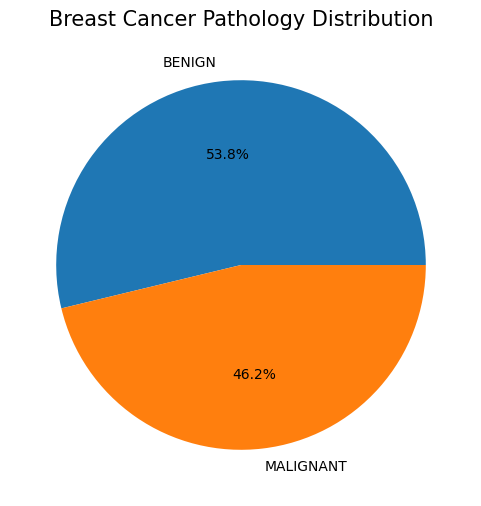

In [20]:
# Pathology distribution
value = mass_df['pathology'].value_counts()
plt.figure(figsize=(6,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Pathology Distribution', fontsize=15)
plt.show()

I0000 00:00:1756044928.282848    6735 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


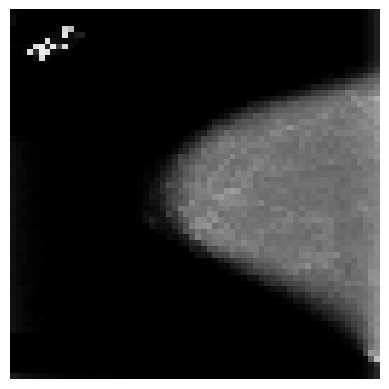

In [21]:
from keras.preprocessing.image import load_img, img_to_array

def load_image(image, SIZE):
    return np.round(tf.image.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

show_image(load_image(mass_df.iloc[12]['image_file_path'], 64))

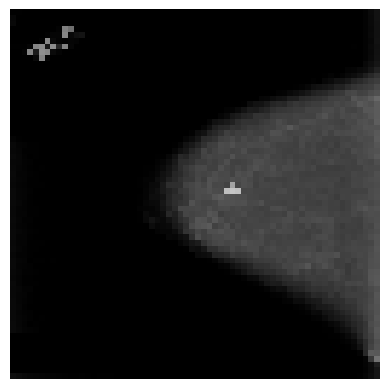

In [22]:
show_mask(load_image(mass_df.iloc[12]['image_file_path'], 64), load_image(mass_df.iloc[12]['ROI_mask_file_path'], 64))

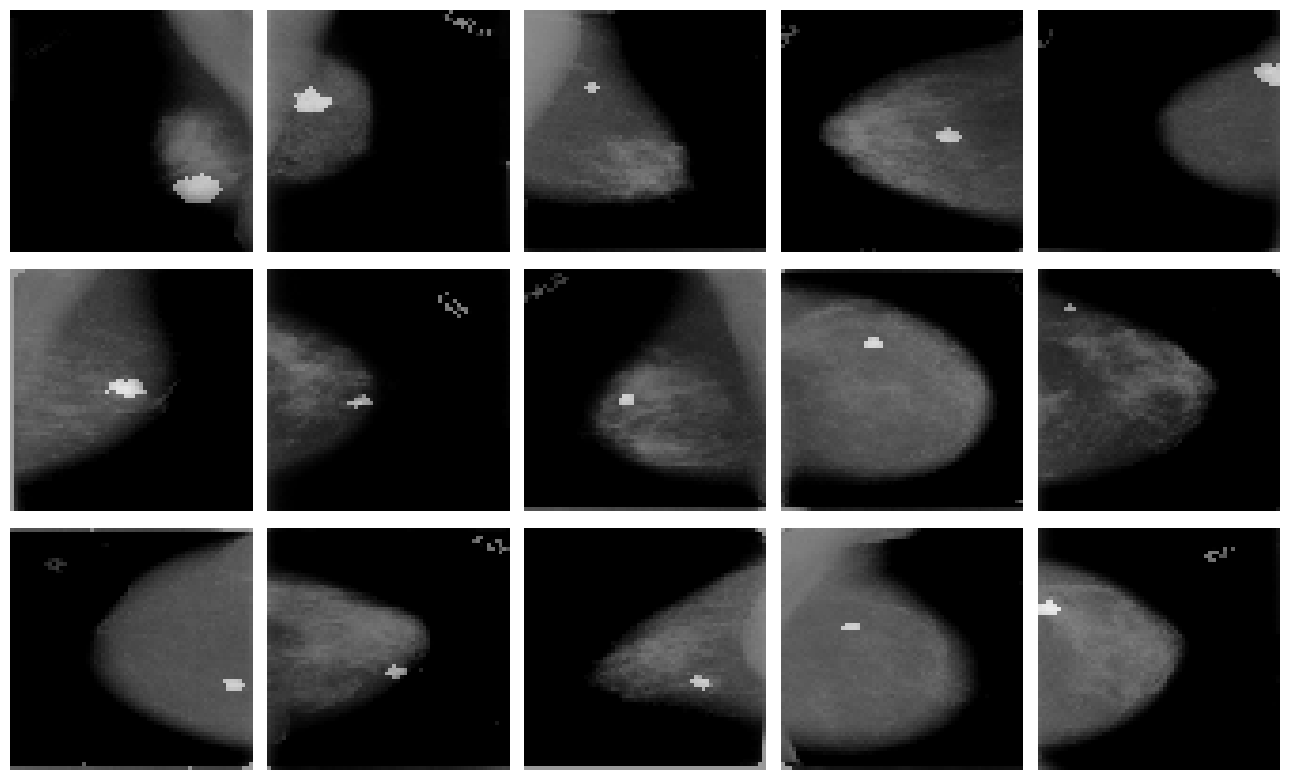

In [23]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    # Select a random row from the mass_df DataFrame
    random_row = mass_df.sample(1).iloc[0]
    cropped_image_path = random_row['image_file_path']
    mask_image_path = random_row['ROI_mask_file_path']

    # Load and display the image and mask
    show_mask(load_image(cropped_image_path, 64), load_image(mask_image_path, 64), cmap='jet')

plt.tight_layout()
plt.show()

In [24]:
from tensorflow.keras.layers import (
    Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, BatchNormalization,
    UpSampling2D, Activation, Add, Multiply, Concatenate, Input
)
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Metrics
from keras.metrics import MeanIoU
class IoUMetric(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=2, name="iou", **kwargs):
        super().__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.int32)
        y_true = tf.cast(y_true, tf.int32)
        return super().update_state(y_true, y_pred, sample_weight)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    y_pred_f = tf.round(y_pred_f)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2.*intersection + smooth)/(tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return 0.5 * bce + (1-0.5)* (1 - dice_coef(y_true, y_pred))

import tensorflow as tf
from sklearn.model_selection import train_test_split

def process_image(image_path, mask_path, size):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [size, size])

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [size, size])
    mask = tf.round(mask) # Masks should be binary

    return img, mask

def create_dataset(dataframe, size, batch_size):
    image_paths = dataframe['image_file_path'].values
    mask_paths = dataframe['ROI_mask_file_path'].values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda x, y: process_image(x, y, size))
    dataset = dataset.shuffle(buffer_size=500).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

SIZE = 64
BATCH_SIZE = 32

# Split data into training and validation sets
train_df, val_df = train_test_split(mass_df, test_size=0.2, random_state=42)

# Create TensorFlow datasets
train_dataset = create_dataset(train_df, SIZE, BATCH_SIZE)
val_dataset = create_dataset(val_df, SIZE, BATCH_SIZE)

def conv_block(x, filters, rate=0.0, name=None):
    x = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if rate > 0:
        x = Dropout(rate)(x)
    x = Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def encoder_block(x, filters, rate=0.0, pooling=True, name=None):
    c = conv_block(x, filters, rate, name)
    if pooling:
        p = MaxPooling2D()(c)
        return p, c
    else:
        return c


def attention_gate(g, skip, filters, name=None):
    # 1x1 convs to match channels
    g1 = Conv2D(filters, 1, padding="same")(g)
    s1 = Conv2D(filters, 1, padding="same", strides=2)(skip)
    x = Activation("relu")(Add()([g1, s1]))
    x = Conv2D(1, 1, activation="sigmoid")(x)
    x = UpSampling2D()(x)
    return Multiply()([skip, x])


def decoder_block(x, skip, filters, rate=0.0, name=None):
    x = Conv2DTranspose(filters, 3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if skip is not None:
        x = Concatenate()([x, skip])
    x = conv_block(x, filters, rate, name)
    return x


# --------- Model --------- #
img_shape = (64, 64, 3)
inputs = Input(img_shape)

# Encoder
p1, c1 = encoder_block(inputs, 32, name="Enc1")
p2, c2 = encoder_block(p1, 64, name="Enc2")
p3, c3 = encoder_block(p2, 128, name="Enc3")
p4, c4 = encoder_block(p3, 256, rate=0.3, name="Enc4")

# Bottleneck
bn = encoder_block(p4, 512, rate=0.3, pooling=False, name="Bottleneck")

# Decoder with Attention
a1 = attention_gate(bn, c4, 256)
d1 = decoder_block(bn, a1, 256, name="Dec1")

a2 = attention_gate(d1, c3, 128)
d2 = decoder_block(d1, a2, 128, name="Dec2")

a3 = attention_gate(d2, c2, 64)
d3 = decoder_block(d2, a3, 64, name="Dec3")

a4 = attention_gate(d3, c1, 32)
d4 = decoder_block(d3, a4, 32, name="Dec4")

# Output
outputs = Conv2D(1, 1, activation="sigmoid")(d4)

model = Model(inputs, outputs, name="AttentionUNetSimple")

# Compile
model.compile(
    loss=bce_dice_loss,
    optimizer="adam",
    metrics=[IoUMetric(num_classes=2), dice_coef]
)

model.summary()

Model: "AttentionUNetSimple"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_4[0][0]  

 Total params: 8,906,757 (33.98 MB)

 Trainable params: 8,899,909 (33.95 MB)

 Non-trainable params: 6,848 (26.75 KB)

In [25]:
callbacks = [
    ModelCheckpoint("attention_unet_best.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


2025-08-24 14:16:18.150878: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 79 of 500
2025-08-24 14:16:37.269852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 234 of 500
2025-08-24 14:16:56.075436: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 375 of 500
2025-08-24 14:17:07.958911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 434 of 500
2025-08-24 14:17:16.565831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.
2025-08-24 14:17:17.573994: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fd17c0537d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-24 14:17:17.574046: 

 1/43 ━━━━━━━━━━━━━━━━━━━━ 1:26:27 124s/step - accuracy: 0.7251 - dice_coef: 0.0135 - iou: 0.3657 - loss: 0.7776

I0000 00:00:1756045073.092757    7018 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9308 - dice_coef: 0.0104 - iou: 0.4692 - loss: 0.6759

2025-08-24 14:20:02.424572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 57 of 500
2025-08-24 14:20:12.930685: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 126 of 500
2025-08-24 14:20:23.570682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 207 of 500
2025-08-24 14:20:32.847334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 291s 4s/step - accuracy: 0.9750 - dice_coef: 0.0046 - iou: 0.4911 - loss: 0.6249 - val_accuracy: 0.9469 - val_dice_coef: 0.0115 - val_iou: 0.4763 - val_loss: 0.6775 - learning_rate: 0.0010
Epoch 2/50


2025-08-24 14:20:50.584541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 59 of 500
2025-08-24 14:21:03.948318: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 127 of 500
2025-08-24 14:21:20.421325: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 243 of 500
2025-08-24 14:21:31.036302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 307 of 500
2025-08-24 14:21:54.231825: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 462 of 500
2025-08-24 14:22:00.601441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9948 - dice_coef: 2.2982e-05 - iou: 0.4974 - loss: 0.5613

2025-08-24 14:24:13.159623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 28 of 500
2025-08-24 14:24:31.929822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 149 of 500
2025-08-24 14:24:50.393782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 272 of 500
2025-08-24 14:24:51.986102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.9946 - dice_coef: 5.9177e-05 - iou: 0.4973 - loss: 0.5558 - val_accuracy: 0.9950 - val_dice_coef: 1.6383e-09 - val_iou: 0.4975 - val_loss: 0.6119 - learning_rate: 0.0010
Epoch 3/50


2025-08-24 14:25:03.283023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 20 of 500
2025-08-24 14:25:14.005840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 87 of 500
2025-08-24 14:25:33.812979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 220 of 500
2025-08-24 14:25:45.370020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 292 of 500
2025-08-24 14:26:04.077724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 395 of 500
2025-08-24 14:26:17.596604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 499 o

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9948 - dice_coef: 1.5413e-09 - iou: 0.4974 - loss: 0.5423

2025-08-24 14:28:36.893205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 21 of 500
2025-08-24 14:28:51.665231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 128 of 500
2025-08-24 14:29:07.331676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 203 of 500
2025-08-24 14:29:18.038406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 275 of 500
2025-08-24 14:29:18.824594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 267s 4s/step - accuracy: 0.9947 - dice_coef: 1.5760e-09 - iou: 0.4974 - loss: 0.5397 - val_accuracy: 0.9950 - val_dice_coef: 1.6166e-09 - val_iou: 0.4975 - val_loss: 0.5602 - learning_rate: 0.0010
Epoch 4/50


2025-08-24 14:29:31.827904: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 31 of 500
2025-08-24 14:29:42.206530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 109 of 500
2025-08-24 14:29:54.327301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 182 of 500
2025-08-24 14:30:11.425336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 282 of 500
2025-08-24 14:30:22.951590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 347 of 500
2025-08-24 14:30:34.247554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 415 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9947 - dice_coef: 3.4177e-05 - iou: 0.4974 - loss: 0.5322

2025-08-24 14:33:06.503693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 28 of 500
2025-08-24 14:33:27.231653: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 157 of 500
2025-08-24 14:33:38.219646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 224 of 500
2025-08-24 14:33:46.834873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 268s 4s/step - accuracy: 0.9948 - dice_coef: 2.7991e-04 - iou: 0.4975 - loss: 0.5301 - val_accuracy: 0.9950 - val_dice_coef: 1.6323e-09 - val_iou: 0.4975 - val_loss: 0.5412 - learning_rate: 0.0010
Epoch 5/50


2025-08-24 14:33:58.223104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23 of 500
2025-08-24 14:34:08.974972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 89 of 500
2025-08-24 14:34:28.805889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 215 of 500
2025-08-24 14:34:40.162003: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 282 of 500
2025-08-24 14:34:59.751053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 415 of 500
2025-08-24 14:35:09.846376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 478 o

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9949 - dice_coef: 0.0048 - iou: 0.4988 - loss: 0.5230

2025-08-24 14:37:28.018589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 24 of 500
2025-08-24 14:37:40.072980: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 109 of 500
2025-08-24 14:37:57.331061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 219 of 500
2025-08-24 14:38:06.178101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.9949 - dice_coef: 0.0176 - iou: 0.5020 - loss: 0.5159 - val_accuracy: 0.9950 - val_dice_coef: 1.6181e-09 - val_iou: 0.4975 - val_loss: 0.5295 - learning_rate: 0.0010
Epoch 6/50


2025-08-24 14:38:18.006247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26 of 500
2025-08-24 14:38:28.352441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 95 of 500
2025-08-24 14:38:52.106039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 244 of 500
2025-08-24 14:39:09.912947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 362 of 500
2025-08-24 14:39:30.468553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 483 of 500
2025-08-24 14:39:30.633137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9950 - dice_coef: 0.0424 - iou: 0.5092 - loss: 0.4996

2025-08-24 14:41:52.346307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 18 of 500
2025-08-24 14:42:03.779188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 98 of 500
2025-08-24 14:42:13.867901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 177 of 500
2025-08-24 14:42:30.526802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 264s 4s/step - accuracy: 0.9950 - dice_coef: 0.0848 - iou: 0.5213 - loss: 0.4777 - val_accuracy: 0.9950 - val_dice_coef: 0.0206 - val_iou: 0.5031 - val_loss: 0.5099 - learning_rate: 0.0010
Epoch 7/50


2025-08-24 14:42:44.372726: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 50 of 500
2025-08-24 14:43:01.838474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 148 of 500
2025-08-24 14:43:12.613199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 227 of 500
2025-08-24 14:43:32.778574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 343 of 500
2025-08-24 14:43:43.264027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 410 of 500
2025-08-24 14:43:57.208309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 499 

42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9951 - dice_coef: 0.1668 - iou: 0.5476 - loss: 0.4342

2025-08-24 14:46:12.458765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 24 of 500
2025-08-24 14:46:22.791055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 89 of 500
2025-08-24 14:46:34.038715: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 165 of 500
2025-08-24 14:46:49.911229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.9952 - dice_coef: 0.1874 - iou: 0.5525 - loss: 0.4234 - val_accuracy: 0.9951 - val_dice_coef: 0.0995 - val_iou: 0.5240 - val_loss: 0.4678 - learning_rate: 0.0010
Epoch 8/50


2025-08-24 14:47:02.541565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26 of 500
2025-08-24 14:47:12.836047: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 91 of 500
2025-08-24 14:47:31.363734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 212 of 500
2025-08-24 14:47:42.595345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 282 of 500
2025-08-24 14:48:01.205294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 405 of 500
2025-08-24 14:48:14.973114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 478 o

42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9951 - dice_coef: 0.1733 - iou: 0.5473 - loss: 0.4290

2025-08-24 14:50:27.102524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 24 of 500
2025-08-24 14:50:38.462673: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 86 of 500
2025-08-24 14:50:49.249559: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 151 of 500
2025-08-24 14:51:06.426490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 287 of 500
2025-08-24 14:51:07.127309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.9952 - dice_coef: 0.2262 - iou: 0.5641 - loss: 0.4040 - val_accuracy: 0.9952 - val_dice_coef: 0.2146 - val_iou: 0.5607 - val_loss: 0.4072 - learning_rate: 0.0010
Epoch 9/50


2025-08-24 14:51:18.618443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26 of 500
2025-08-24 14:51:34.983799: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 148 of 500
2025-08-24 14:51:51.092614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 227 of 500
2025-08-24 14:52:08.458668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 372 of 500
2025-08-24 14:52:21.186925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 434 of 500
2025-08-24 14:52:28.937639: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9952 - dice_coef: 0.1405 - iou: 0.5383 - loss: 0.4443

2025-08-24 14:54:43.287346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 21 of 500
2025-08-24 14:55:03.035290: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 151 of 500
2025-08-24 14:55:13.266730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 246 of 500
2025-08-24 14:55:20.683627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 254s 4s/step - accuracy: 0.9952 - dice_coef: 0.1983 - iou: 0.5565 - loss: 0.4156 - val_accuracy: 0.9949 - val_dice_coef: 0.2548 - val_iou: 0.5719 - val_loss: 0.3882 - learning_rate: 0.0010
Epoch 10/50


2025-08-24 14:55:32.408324: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22 of 500
2025-08-24 14:55:43.289312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 95 of 500
2025-08-24 14:56:05.017999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 227 of 500
2025-08-24 14:56:26.002305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 371 of 500
2025-08-24 14:56:36.888498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9954 - dice_coef: 0.2588 - iou: 0.5747 - loss: 0.3832

2025-08-24 14:58:54.209351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 24 of 500
2025-08-24 14:59:13.598598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 175 of 500
2025-08-24 14:59:25.223637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 229 of 500
2025-08-24 14:59:31.872481: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.9954 - dice_coef: 0.3043 - iou: 0.5898 - loss: 0.3616 - val_accuracy: 0.9950 - val_dice_coef: 0.2597 - val_iou: 0.5785 - val_loss: 0.3787 - learning_rate: 0.0010
Epoch 11/50


2025-08-24 14:59:43.322355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18 of 500
2025-08-24 15:00:04.331150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 168 of 500
2025-08-24 15:00:16.274831: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 241 of 500
2025-08-24 15:00:26.476604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 307 of 500
2025-08-24 15:00:43.870935: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 418 of 500
2025-08-24 15:00:59.547667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 499 

42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9952 - dice_coef: 0.2804 - iou: 0.5812 - loss: 0.3718

2025-08-24 15:03:06.681513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 18 of 500
2025-08-24 15:03:18.276275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 86 of 500
2025-08-24 15:03:28.760565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 151 of 500
2025-08-24 15:03:46.204257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 285 of 500
2025-08-24 15:03:47.537433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.9954 - dice_coef: 0.3241 - iou: 0.5983 - loss: 0.3491 - val_accuracy: 0.9953 - val_dice_coef: 0.2004 - val_iou: 0.5549 - val_loss: 0.4089 - learning_rate: 0.0010
Epoch 12/50


2025-08-24 15:03:59.702801: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18 of 500
2025-08-24 15:04:18.423842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 148 of 500
2025-08-24 15:04:31.133113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 227 of 500
2025-08-24 15:04:48.978337: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 343 of 500
2025-08-24 15:05:08.171700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 477 of 500
2025-08-24 15:05:11.234957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9956 - dice_coef: 0.3225 - iou: 0.5958 - loss: 0.3495

2025-08-24 15:07:25.713010: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 21 of 500
2025-08-24 15:07:45.637169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 151 of 500
2025-08-24 15:07:56.984991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 240 of 500
2025-08-24 15:08:03.485762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.9955 - dice_coef: 0.3484 - iou: 0.6058 - loss: 0.3357 - val_accuracy: 0.9953 - val_dice_coef: 0.2979 - val_iou: 0.5906 - val_loss: 0.3591 - learning_rate: 0.0010
Epoch 13/50


2025-08-24 15:08:15.034827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18 of 500
2025-08-24 15:08:26.210320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 89 of 500
2025-08-24 15:08:47.689151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 233 of 500
2025-08-24 15:09:09.806728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 373 of 500
2025-08-24 15:09:30.898738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 499 of 500
2025-08-24 15:09:30.931265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9953 - dice_coef: 0.3612 - iou: 0.6119 - loss: 0.3300

2025-08-24 15:11:48.378981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 20 of 500
2025-08-24 15:11:59.182976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 111 of 500
2025-08-24 15:12:10.331623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 175 of 500
2025-08-24 15:12:26.240429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 263s 4s/step - accuracy: 0.9956 - dice_coef: 0.3734 - iou: 0.6168 - loss: 0.3230 - val_accuracy: 0.9945 - val_dice_coef: 0.3838 - val_iou: 0.6184 - val_loss: 0.3217 - learning_rate: 0.0010
Epoch 14/50


2025-08-24 15:12:37.642918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18 of 500
2025-08-24 15:12:48.747981: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 95 of 500
2025-08-24 15:13:09.515299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 227 of 500
2025-08-24 15:13:30.404602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 373 of 500
2025-08-24 15:13:47.271512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9957 - dice_coef: 0.4124 - iou: 0.6311 - loss: 0.3033

2025-08-24 15:16:01.179734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 41 of 500
2025-08-24 15:16:13.674949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 109 of 500
2025-08-24 15:16:31.020060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 251 of 500
2025-08-24 15:16:38.282146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.9957 - dice_coef: 0.4163 - iou: 0.6350 - loss: 0.3007 - val_accuracy: 0.9954 - val_dice_coef: 0.2969 - val_iou: 0.5863 - val_loss: 0.3640 - learning_rate: 0.0010
Epoch 15/50


2025-08-24 15:16:49.542257: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18 of 500
2025-08-24 15:17:08.974247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 148 of 500
2025-08-24 15:17:29.288795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 302 of 500
2025-08-24 15:17:40.085650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 395 of 500
2025-08-24 15:17:58.467109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9960 - dice_coef: 0.4636 - iou: 0.6518 - loss: 0.2769

2025-08-24 15:20:10.065936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 35 of 500
2025-08-24 15:20:20.674939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 109 of 500
2025-08-24 15:20:37.581587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 251 of 500
2025-08-24 15:20:46.365115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 248s 4s/step - accuracy: 0.9958 - dice_coef: 0.4419 - iou: 0.6424 - loss: 0.2872 - val_accuracy: 0.9952 - val_dice_coef: 0.2886 - val_iou: 0.5846 - val_loss: 0.3635 - learning_rate: 0.0010
Epoch 16/50


2025-08-24 15:20:57.406941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18 of 500
2025-08-24 15:21:19.887267: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 190 of 500
2025-08-24 15:21:45.203574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 347 of 500
2025-08-24 15:21:57.598967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 477 of 500
2025-08-24 15:22:06.116176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9961 - dice_coef: 0.4412 - iou: 0.6434 - loss: 0.2878

2025-08-24 15:24:22.115755: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 28 of 500
2025-08-24 15:24:34.022414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 99 of 500
2025-08-24 15:24:55.371285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 240 of 500
2025-08-24 15:25:01.328895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.9959 - dice_coef: 0.4556 - iou: 0.6498 - loss: 0.2806 - val_accuracy: 0.9953 - val_dice_coef: 0.3064 - val_iou: 0.5893 - val_loss: 0.3578 - learning_rate: 0.0010
Epoch 17/50


2025-08-24 15:25:12.010677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24 of 500
2025-08-24 15:25:32.266323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 164 of 500
2025-08-24 15:25:53.803461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 301 of 500
2025-08-24 15:26:13.822505: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 441 of 500
2025-08-24 15:26:19.844533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9959 - dice_coef: 0.4743 - iou: 0.6555 - loss: 0.2710

2025-08-24 15:28:35.790569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 35 of 500
2025-08-24 15:28:47.690812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 111 of 500
2025-08-24 15:29:04.348266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 222 of 500
2025-08-24 15:29:12.383867: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 251s 4s/step - accuracy: 0.9959 - dice_coef: 0.4857 - iou: 0.6605 - loss: 0.2648 - val_accuracy: 0.9952 - val_dice_coef: 0.1639 - val_iou: 0.5442 - val_loss: 0.4284 - learning_rate: 0.0010
Epoch 18/50


2025-08-24 15:29:23.998584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18 of 500
2025-08-24 15:29:42.712120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 162 of 500
2025-08-24 15:29:52.897323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 227 of 500
2025-08-24 15:30:03.361826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 285 of 500
2025-08-24 15:30:15.749140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 358 of 500
2025-08-24 15:30:35.467773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 493 

42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9960 - dice_coef: 0.4948 - iou: 0.6666 - loss: 0.2605

2025-08-24 15:32:49.091515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 41 of 500
2025-08-24 15:33:01.752728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 86 of 500
2025-08-24 15:33:20.764832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 216 of 500
2025-08-24 15:33:29.419034: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 258s 4s/step - accuracy: 0.9960 - dice_coef: 0.5014 - iou: 0.6685 - loss: 0.2571 - val_accuracy: 0.9949 - val_dice_coef: 0.3898 - val_iou: 0.6200 - val_loss: 0.3130 - learning_rate: 0.0010
Epoch 19/50


2025-08-24 15:33:43.371992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 56 of 500
2025-08-24 15:34:00.705932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 165 of 500
2025-08-24 15:34:12.172555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 235 of 500
2025-08-24 15:34:31.161142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 376 of 500
2025-08-24 15:34:41.325490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 434 of 500
2025-08-24 15:34:49.774294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9960 - dice_coef: 0.5030 - iou: 0.6680 - loss: 0.2562

2025-08-24 15:37:00.697550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 35 of 500
2025-08-24 15:37:12.739119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 120 of 500
2025-08-24 15:37:31.004211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 236 of 500
2025-08-24 15:37:37.650874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 247s 4s/step - accuracy: 0.9961 - dice_coef: 0.5148 - iou: 0.6730 - loss: 0.2512 - val_accuracy: 0.9952 - val_dice_coef: 0.2715 - val_iou: 0.5828 - val_loss: 0.3708 - learning_rate: 0.0010
Epoch 20/50


2025-08-24 15:37:49.012375: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26 of 500
2025-08-24 15:37:59.588809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 102 of 500
2025-08-24 15:38:11.453156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 168 of 500
2025-08-24 15:38:33.878217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 307 of 500
2025-08-24 15:38:49.408239: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 434 of 500
2025-08-24 15:38:57.072127: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9966 - dice_coef: 0.5815 - iou: 0.7062 - loss: 0.2159

2025-08-24 15:41:14.720309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 24 of 500
2025-08-24 15:41:35.082672: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 151 of 500
2025-08-24 15:41:53.023806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.9964 - dice_coef: 0.5742 - iou: 0.7025 - loss: 0.2191 - val_accuracy: 0.9953 - val_dice_coef: 0.1782 - val_iou: 0.5477 - val_loss: 0.4219 - learning_rate: 0.0010
Epoch 21/50


2025-08-24 15:42:04.391186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24 of 500
2025-08-24 15:42:24.210449: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 168 of 500
2025-08-24 15:42:46.983841: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 311 of 500
2025-08-24 15:43:06.248907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 434 of 500
2025-08-24 15:43:16.283422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 499 of 500
2025-08-24 15:43:16.676392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9966 - dice_coef: 0.5776 - iou: 0.7043 - loss: 0.2176

2025-08-24 15:45:33.180389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 49 of 500
2025-08-24 15:45:50.780080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 218 of 500
2025-08-24 15:46:02.202898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 263 of 500
2025-08-24 15:46:03.114367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.9965 - dice_coef: 0.5811 - iou: 0.7070 - loss: 0.2153 - val_accuracy: 0.9951 - val_dice_coef: 0.2644 - val_iou: 0.5781 - val_loss: 0.3764 - learning_rate: 0.0010
Epoch 22/50


2025-08-24 15:46:13.460804: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 22 of 500
2025-08-24 15:46:24.194590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 98 of 500
2025-08-24 15:46:35.077145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 164 of 500
2025-08-24 15:46:45.738909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 220 of 500
2025-08-24 15:47:05.378094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 372 of 500
2025-08-24 15:47:23.219088: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9966 - dice_coef: 0.5930 - iou: 0.7127 - loss: 0.2099

2025-08-24 15:49:38.323090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 18 of 500
2025-08-24 15:49:49.030958: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 86 of 500
2025-08-24 15:49:59.255142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 151 of 500
2025-08-24 15:50:09.305956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 245 of 500
2025-08-24 15:50:16.380456: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 253s 4s/step - accuracy: 0.9967 - dice_coef: 0.6054 - iou: 0.7217 - loss: 0.2021 - val_accuracy: 0.9950 - val_dice_coef: 0.3175 - val_iou: 0.5944 - val_loss: 0.3504 - learning_rate: 0.0010
Epoch 23/50


2025-08-24 15:50:26.841654: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 23 of 500
2025-08-24 15:50:47.819483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 157 of 500
2025-08-24 15:50:59.004623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 227 of 500
2025-08-24 15:51:17.216259: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 357 of 500
2025-08-24 15:51:29.559322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 434 of 500
2025-08-24 15:51:36.396168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9968 - dice_coef: 0.6129 - iou: 0.7236 - loss: 0.1996

2025-08-24 15:53:47.435729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 28 of 500
2025-08-24 15:53:58.747635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 111 of 500
2025-08-24 15:54:17.991667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 285 of 500
2025-08-24 15:54:22.553024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step - accuracy: 0.9968 - dice_coef: 0.6231 - iou: 0.7284 - loss: 0.1950 - val_accuracy: 0.9950 - val_dice_coef: 0.2976 - val_iou: 0.5885 - val_loss: 0.3620 - learning_rate: 0.0010
Epoch 24/50


2025-08-24 15:54:33.082836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 26 of 500
2025-08-24 15:54:44.161421: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 89 of 500
2025-08-24 15:55:04.360888: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 215 of 500
2025-08-24 15:55:26.971467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 362 of 500
2025-08-24 15:55:43.198039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 499 of 500
2025-08-24 15:55:49.163125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9972 - dice_coef: 0.6798 - iou: 0.7592 - loss: 0.1653

2025-08-24 15:58:05.259144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 41 of 500
2025-08-24 15:58:23.464647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 151 of 500
2025-08-24 15:58:41.115866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 292 of 500
2025-08-24 15:58:41.312229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.9973 - dice_coef: 0.6998 - iou: 0.7707 - loss: 0.1546 - val_accuracy: 0.9952 - val_dice_coef: 0.3061 - val_iou: 0.5879 - val_loss: 0.3591 - learning_rate: 5.0000e-04
Epoch 25/50


2025-08-24 15:58:51.700058: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 24 of 500
2025-08-24 15:59:04.805327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 120 of 500
2025-08-24 15:59:23.856950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 235 of 500
2025-08-24 15:59:34.112728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 300 of 500
2025-08-24 15:59:52.103369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 459 of 500
2025-08-24 15:59:59.883314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9974 - dice_coef: 0.7273 - iou: 0.7861 - loss: 0.1410

2025-08-24 16:02:18.581233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 18 of 500
2025-08-24 16:02:29.642423: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 86 of 500
2025-08-24 16:02:49.535677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 218 of 500
2025-08-24 16:02:58.420274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step - accuracy: 0.9975 - dice_coef: 0.7276 - iou: 0.7889 - loss: 0.1399 - val_accuracy: 0.9952 - val_dice_coef: 0.2164 - val_iou: 0.5601 - val_loss: 0.4033 - learning_rate: 5.0000e-04
Epoch 26/50


2025-08-24 16:03:08.903332: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 64 of 500
2025-08-24 16:03:28.686650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 171 of 500
2025-08-24 16:03:40.076476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 251 of 500
2025-08-24 16:03:52.086250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 347 of 500
2025-08-24 16:04:09.579008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 464 of 500
2025-08-24 16:04:20.036854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9974 - dice_coef: 0.7193 - iou: 0.7826 - loss: 0.1449

2025-08-24 16:06:37.271982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 24 of 500
2025-08-24 16:06:49.562777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 122 of 500
2025-08-24 16:07:09.010011: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 222 of 500
2025-08-24 16:07:17.075645: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.9976 - dice_coef: 0.7415 - iou: 0.7957 - loss: 0.1333 - val_accuracy: 0.9951 - val_dice_coef: 0.2855 - val_iou: 0.5806 - val_loss: 0.3696 - learning_rate: 5.0000e-04
Epoch 27/50


2025-08-24 16:07:28.310479: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18 of 500
2025-08-24 16:07:49.313535: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 180 of 500
2025-08-24 16:07:59.689506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 245 of 500
2025-08-24 16:08:20.799792: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 373 of 500
2025-08-24 16:08:38.974586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 481 of 500
2025-08-24 16:08:38.986530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9978 - dice_coef: 0.7617 - iou: 0.8071 - loss: 0.1232

2025-08-24 16:10:53.087947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 24 of 500
2025-08-24 16:11:03.462148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 86 of 500
2025-08-24 16:11:15.554351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 192 of 500
2025-08-24 16:11:27.042499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 243 of 500
2025-08-24 16:11:32.782124: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.9977 - dice_coef: 0.7621 - iou: 0.8077 - loss: 0.1231 - val_accuracy: 0.9951 - val_dice_coef: 0.2822 - val_iou: 0.5820 - val_loss: 0.3714 - learning_rate: 5.0000e-04
Epoch 28/50


2025-08-24 16:11:43.535283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 18 of 500
2025-08-24 16:11:55.263348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 137 of 500
2025-08-24 16:12:14.144120: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 227 of 500
2025-08-24 16:12:33.374982: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 371 of 500
2025-08-24 16:12:43.784757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 464 of 500
2025-08-24 16:12:54.593244: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 499 

42/43 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - accuracy: 0.9978 - dice_coef: 0.7716 - iou: 0.8138 - loss: 0.1181

2025-08-24 16:15:12.840319: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 24 of 500
2025-08-24 16:15:32.460775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 151 of 500
2025-08-24 16:15:50.982725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 281 of 500
2025-08-24 16:15:51.354434: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


43/43 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.9977 - dice_coef: 0.7625 - iou: 0.8094 - loss: 0.1213 - val_accuracy: 0.9952 - val_dice_coef: 0.2575 - val_iou: 0.5774 - val_loss: 0.3837 - learning_rate: 5.0000e-04


2025-08-24 16:56:30.572432: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 23 of 500
2025-08-24 16:56:54.290557: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 180 of 500
2025-08-24 16:57:06.936538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


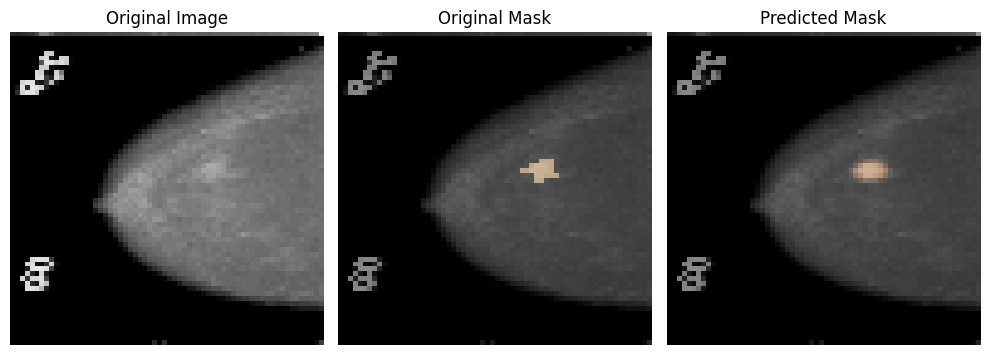

In [46]:
# Load the saved model
loaded_model = tf.keras.models.load_model(
    'attention_unet_best.h5',
    custom_objects={
        'bce_dice_loss': bce_dice_loss,
        'dice_coef': dice_coef,
        'IoUMetric': IoUMetric
    }
)

# Get an image and mask from the validation dataset
for images, masks in val_dataset.take(1):
    break

# Select a random image and its corresponding mask from the batch
id = np.random.randint(len(images))
image = images[id]
mask = masks[id]

# Make a prediction
pred_mask = loaded_model.predict(image[np.newaxis, ...])

# Display the original image, original mask, and predicted mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
show_image(image)

plt.subplot(1, 3, 2)
plt.title("Original Mask")
show_mask(image, mask, cmap='copper')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
show_mask(image, pred_mask, cmap='copper')

plt.tight_layout()
plt.show()

In [33]:
# Evaluate the model on the test dataset
results = loaded_model.evaluate(test_dataset)

# Print the evaluation results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])
print("Test IoU:", results[2])

NameError: name 'test_dataset' is not defined

In [37]:
def create_test_dataset(dataframe, size, batch_size):
    image_paths = dataframe['image_file_path'].values
    mask_paths = dataframe['ROI_mask_file_path'].values

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda x, y: process_image(x, y, size),
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# ---------------- Parameters ---------------- #
SIZE = 64
BATCH_SIZE = 32

# ---------------- Evaluate ---------------- #
results = loaded_model.evaluate(val_dataset)
for name, value in zip(loaded_model.metrics_names, results):
    print(f"{name}: {value:.4f}")

2025-08-24 16:36:42.375951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 24 of 500
2025-08-24 16:36:53.521012: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 86 of 500
2025-08-24 16:37:13.019800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:453] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 218 of 500
2025-08-24 16:37:22.291039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:483] Shuffle buffer filled.


11/11 ━━━━━━━━━━━━━━━━━━━━ 56s 191ms/step - accuracy: 0.9949 - dice_coef: 0.3952 - iou: 0.6200 - loss: 0.3130
loss: 0.3130
compile_metrics: 0.9949


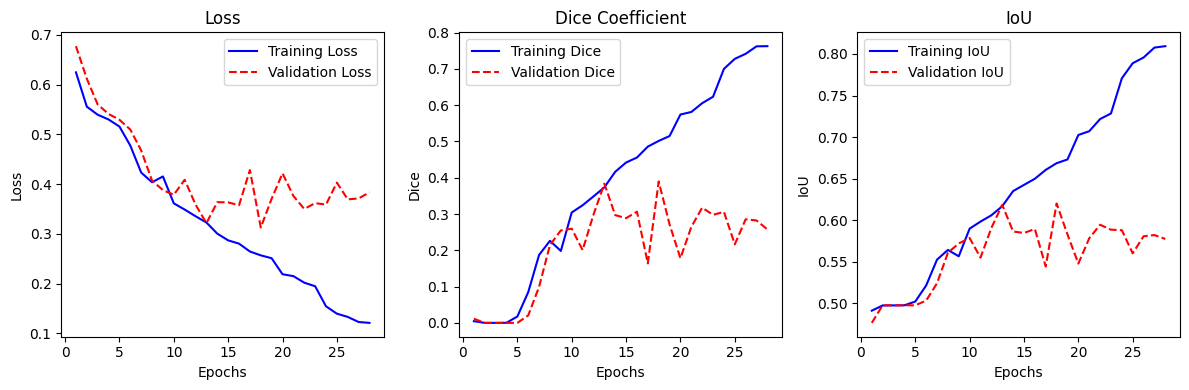

In [45]:
history_dict = history.history
epochs = range(1, len(history_dict['loss']) + 1)

# --------- Loss --------- #
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, history_dict['loss'], 'b-', label='Training Loss')
plt.plot(epochs, history_dict['val_loss'], 'r--', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# --------- Dice --------- #
if 'dice_coef' in history_dict:
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history_dict['dice_coef'], 'b-', label='Training Dice')
    plt.plot(epochs, history_dict['val_dice_coef'], 'r--', label='Validation Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

# --------- IoU --------- #
if 'iou' in history_dict:
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history_dict['iou'], 'b-', label='Training IoU')
    plt.plot(epochs, history_dict['val_iou'], 'r--', label='Validation IoU')
    plt.title('IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

plt.tight_layout()
plt.show()